Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /home/dhruv/AirFleet-Supply-Optimizer/my-pypy-venv/lib/pypy3.11/site-packages/pulp/apis/../solverdir/cbc/linux/i64/cbc /tmp/64f081d7259443c5b93feb6e03777d46-pulp.mps -max -timeMode elapsed -branch -printingOptions all -solution /tmp/64f081d7259443c5b93feb6e03777d46-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 18 COLUMNS
At line 169 RHS
At line 183 BOUNDS
At line 208 ENDATA
Problem MODEL has 13 rows, 24 columns and 78 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 170 - 0.00 seconds
Cgl0008I 3 inequality constraints converted to equality constraints
Cgl0005I 3 SOS with 27 members
Cgl0004I processed model has 13 rows, 27 columns (27 integer (27 of which binary)) and 81 elements
Cutoff increment increased from 1e-05 to 9.9999
Cbc0038I Initial state - 0 integers unsatisfied sum - 0
Cbc0038I

/tmp/ipykernel_2431770/1841662122.py:75: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = cm.get_cmap('tab10', len(rockets))


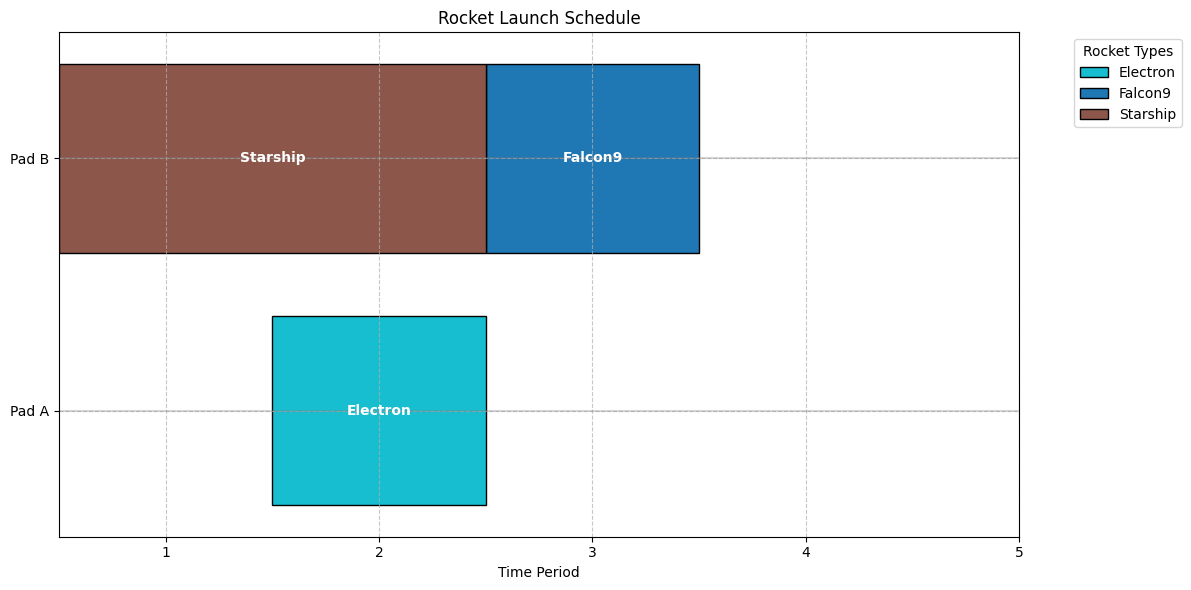

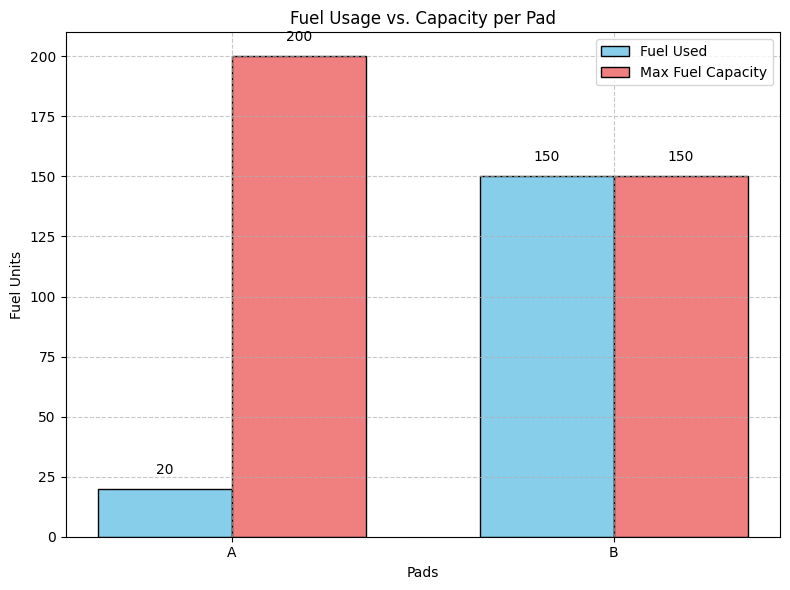

/tmp/ipykernel_2431770/1841662122.py:181: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors=cm.get_cmap('tab10')(np.linspace(0, 1, len(rockets))))


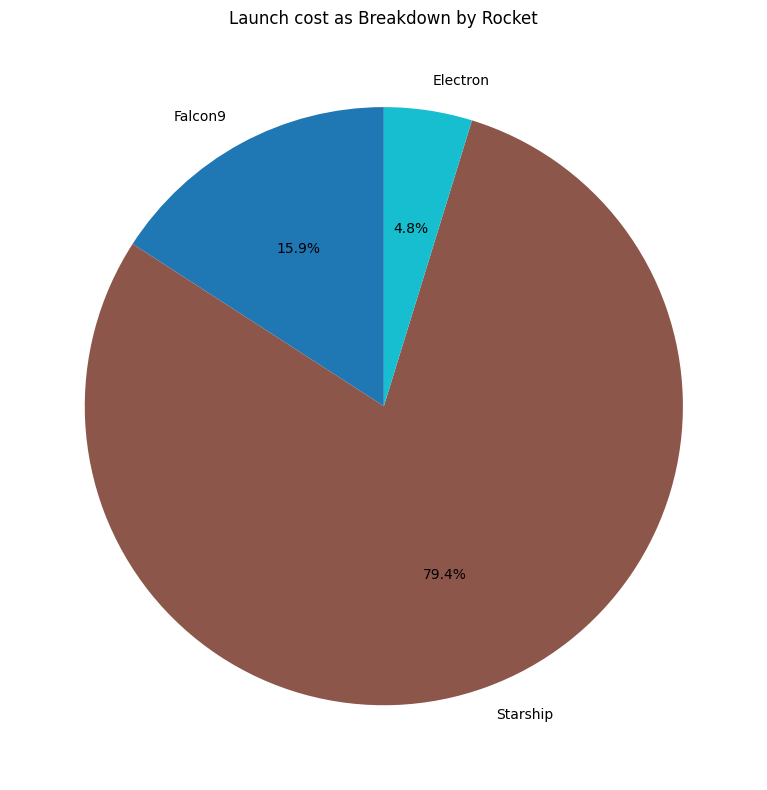

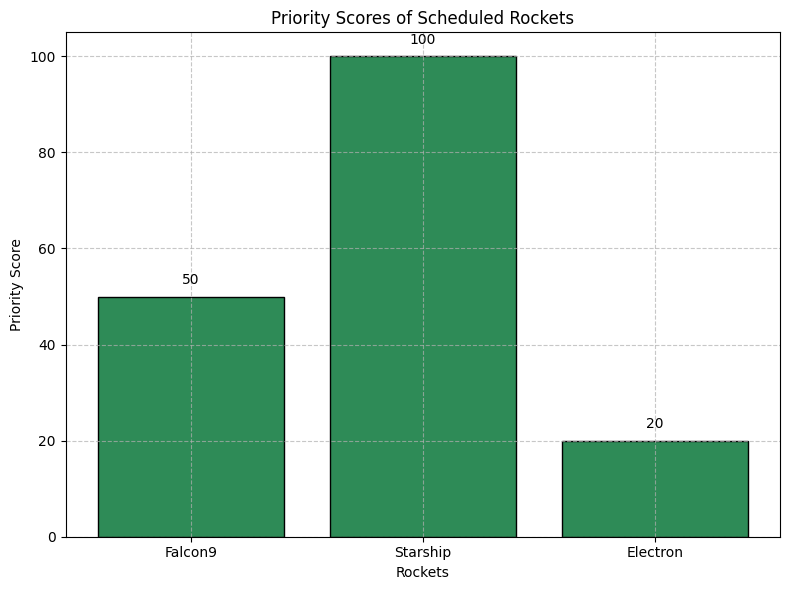

In [29]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib import cm
import pulp as pl
import numpy as np

# --- Data ---
Rockets = ['Falcon9', 'Starship', 'Electron']
Pads = ['Pad_A', 'Pad_B']
Periods = [1, 2, 3, 4]
PrepTime = {'Falcon9': 1, 'Starship': 2, 'Electron': 1}   # periods needed for prep/fuel
FuelCost = {'Falcon9': 50, 'Starship': 100, 'Electron': 20}  # fuel per launch
LaunchCost = {'Falcon9': 100, 'Starship': 500, 'Electron': 30}
Priority = {'Falcon9': 50, 'Starship': 100, 'Electron': 20}  # higher than launch cost to make scheduling attractive
MaxFuelPerPad = {'Pad_A': 200, 'Pad_B': 150}  # total fuel limit per pad

# --- Decision variable ---
# x[r][p][t] = 1 if rocket r launches from pad p at period t
x = pl.LpVariable.dicts("Launch", (Rockets, Pads, Periods), cat='Binary')

# --- Problem ---
prob = pl.LpProblem("Rocket_Launch", pl.LpMaximize)

# --- Objective: maximize total priority score ---
prob += pl.lpSum([Priority[r]*x[r][p][t] for r in Rockets for p in Pads for t in Periods])

# --- Constraints ---

# 1. Each rocket launches at most once
for r in Rockets:
    prob += pl.lpSum([x[r][p][t] for p in Pads for t in Periods]) <= 1

# 2. Pad cannot host overlapping rockets (prep/fuel)
for p in Pads:
    for t in Periods:
        prob += pl.lpSum([x[r][p][tp] 
                         for r in Rockets 
                         for tp in range(max(1, t - PrepTime[r] + 1), t + 1)
                         if tp in Periods]) <= 1

# 3. Fuel limit per pad
for p in Pads:
    prob += pl.lpSum([FuelCost[r] * x[r][p][t] 
                     for r in Rockets 
                     for t in Periods]) <= MaxFuelPerPad[p]  # Fixed: Use MaxFuelPerPad[p]

# --- Solve ---
prob.solve(pl.PULP_CBC_CMD(msg=1))

# --- Extract results ---
Assignments = {}
TotalCost = 0
TotalPriority = 0
FuelUsedPerPad = {p: 0 for p in Pads}

for r in Rockets:
    for p in Pads:
        for t in Periods:
            if pl.value(x[r][p][t]) == 1:
                Assignments[r] = (p, t)
                TotalCost += LaunchCost[r]
                TotalPriority += Priority[r]
                FuelUsedPerPad[p] += FuelCost[r]

# --- Results ---
print("Assignments:", Assignments)
print("Total Launch Cost:", TotalCost)
print("Total Priority Score:", TotalPriority)
print("Fuel Used Per Pad:", FuelUsedPerPad)

# --- Visualization Functions ---

def visualize_schedule(assignments, rockets, pads, periods, prep_time):
    # Create a color map for rockets
    colors = cm.get_cmap('tab10', len(rockets))
    rocket_colors = {rocket: colors(i) for i, rocket in enumerate(rockets)}
    
    # Create figure and axis
    fig, ax = plt.subplots(figsize=(12, 6))
    
    # Create y-axis ticks and labels
    y_ticks = []
    y_labels = []
    
    # Plot each pad
    for pad_idx, pad in enumerate(pads):
        y_pos = pad_idx * 2
        y_ticks.append(y_pos)
        y_labels.append(f'Pad {pad[-1]}')
        
        # Draw pad line
        ax.axhline(y=y_pos, color='gray', linestyle='-', alpha=0.3)
        
        # Plot scheduled launches
        for rocket, (assigned_pad, start_time) in assignments.items():
            if assigned_pad == pad:
                end_time = start_time + prep_time[rocket]
                ax.barh(
                    y_pos, 
                    width=prep_time[rocket],
                    left=start_time - 0.5,  # Center the bar on the time point
                    height=1.5,
                    color=rocket_colors[rocket],
                    edgecolor='black',
                    label=rocket
                )
                # Add rocket name to the bar
                ax.text(
                    start_time + prep_time[rocket]/2 - 0.5, 
                    y_pos, 
                    rocket, 
                    ha='center', 
                    va='center',
                    color='white',
                    fontweight='bold'
                )
    
    # Set y-ticks and labels
    ax.set_yticks(y_ticks)
    ax.set_yticklabels(y_labels)
    ax.set_ylim(-1, len(pads) * 2 - 1)
    
    # Set x-ticks and labels
    ax.set_xticks(range(1, max(periods) + 2))
    ax.set_xlabel('Time Period')
    ax.set_title('Rocket Launch Schedule')
    
    # Add legend (without duplicates)
    handles, labels = ax.get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    ax.legend(by_label.values(), by_label.keys(), 
              title='Rocket Types',
              bbox_to_anchor=(1.05, 1), 
              loc='upper left')
    
    # Add grid
    ax.grid(True, linestyle='--', alpha=0.7)
    
    plt.tight_layout()
    plt.show()

def visualize_fuel_usage(fuel_used_per_pad, max_fuel_per_pad):
    fig, ax = plt.subplots(figsize=(8, 6))
    pads = list(fuel_used_per_pad.keys())
    fuel_used = [fuel_used_per_pad[p] for p in pads]
    max_fuel = [max_fuel_per_pad[p] for p in pads]
    
    x = np.arange(len(pads))
    width = 0.35
    
    ax.bar(x - width/2, fuel_used, width, label='Fuel Used', color='skyblue', edgecolor='black')
    ax.bar(x + width/2, max_fuel, width, label='Max Fuel Capacity', color='lightcoral', edgecolor='black')
    
    ax.set_xlabel('Pads')
    ax.set_ylabel('Fuel Units')
    ax.set_title('Fuel Usage vs. Capacity per Pad')
    ax.set_xticks(x)
    ax.set_xticklabels([p[-1] for p in pads])
    ax.legend()
    ax.grid(True, linestyle='--', alpha=0.7)
    
    # Add value labels on top of bars
    for i, v in enumerate(fuel_used):
        ax.text(i - width/2, v + 5, str(v), ha='center', va='bottom')
    for i, v in enumerate(max_fuel):
        ax.text(i + width/2, v + 5, str(v), ha='center', va='bottom')
    
    plt.tight_layout()
    plt.show()

def visualize_cost_breakdown(assignments, launch_cost):
    if not assignments:
        print("No cost breakdown to visualize (no assignments).")
        return
    
    rockets = [r for r in assignments.keys()]
    costs = [launch_cost[r] for r in rockets]
    
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.pie(costs, labels=rockets, autopct='%1.1f%%', startangle=90, 
           colors=cm.get_cmap('tab10')(np.linspace(0, 1, len(rockets))))
    ax.set_title('Launch cost as Breakdown by Rocket')
    plt.tight_layout()
    plt.show()

def visualize_priority_scores(assignments, priority):
    if not assignments:
        print("No priority scores to visualize (no assignments).")
        return
    
    rockets = [r for r in assignments.keys()]
    scores = [priority[r] for r in rockets]
    
    fig, ax = plt.subplots(figsize=(8, 6))
    bars = ax.bar(rockets, scores, color='seagreen', edgecolor='black')
    
    ax.set_xlabel('Rockets')
    ax.set_ylabel('Priority Score')
    ax.set_title('Priority Scores of Scheduled Rockets')
    ax.grid(True, linestyle='--', alpha=0.7)
    
    # Add value labels on top of bars
    for bar in bars:
        yval = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2, yval + 2, str(int(yval)), 
                ha='center', va='bottom')
    
    plt.tight_layout()
    plt.show()

# --- Execute Visualizations ---
if 'Assignments' in locals() and Assignments:
    visualize_schedule(Assignments, Rockets, Pads, Periods, PrepTime)
    visualize_fuel_usage(FuelUsedPerPad, MaxFuelPerPad)
    visualize_cost_breakdown(Assignments, LaunchCost)
    visualize_priority_scores(Assignments, Priority)
else:
    print("No assignments found. Please run the optimization first.")